In [5]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [6]:
#change the tickers here according to what's in the portfolio
tickers = ['AMD','EPAM','APPS','ASML','AUDC','DSGX','TTD','IDXX','BDSI','CDMO','ICLR','MEDP','OPCH','OPRX','RGEN',
          'TNDM','XOMA','CBRE','SBAC','ODFL','GLDD','HSON', 'KRNT','RCII','SAIA','SBLK','TRNS','HLT','TSLA',
          'CHDN','CLAR','FIVE','FOXF','LULU','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [7]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     1259 non-null   float64
 1   EPAM    1259 non-null   float64
 2   APPS    1259 non-null   float64
 3   ASML    1259 non-null   float64
 4   AUDC    1259 non-null   float64
 5   DSGX    1259 non-null   float64
 6   TTD     1259 non-null   float64
 7   IDXX    1259 non-null   float64
 8   BDSI    1259 non-null   float64
 9   CDMO    1259 non-null   float64
 10  ICLR    1259 non-null   float64
 11  MEDP    1259 non-null   float64
 12  OPCH    1259 non-null   float64
 13  OPRX    1259 non-null   float64
 14  RGEN    1259 non-null   float64
 15  TNDM    1259 non-null   float64
 16  XOMA    1259 non-null   float64
 17  CBRE    1259 non-null   float64
 18  SBAC    1259 non-null   float64
 19  ODFL    1259 non-null   float64
 20  GLDD    1259 non-null   float64
 21  HSON    1259 non-nu

## Function that saves dataframe to CSV

In [8]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [10]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [11]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [12]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [13]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [14]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [15]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [16]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [17]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [18]:
#change to the list of stocks we using
port_list = ['AMD','EPAM','APPS','ASML','AUDC','DSGX','TTD','IDXX','BDSI','CDMO','ICLR','MEDP','OPCH','OPRX','RGEN',
          'TNDM','XOMA','CBRE','SBAC','ODFL','GLDD','HSON', 'KRNT','RCII','SAIA','SBLK','TRNS','HLT','TSLA',
          'CHDN','CLAR','FIVE','FOXF','LULU','^FVX']

#add in the weightage of stocks
port_shares = [0.026583,0.034851,0.096294,0.048018,0.041109,0.006993,0.046149,0.048508,0.008168,0.018970,0.017408,
              0.006022,0.000022,0.043910,0.047034,0.000492,0.009466,0.064368,0.135632,0.079597,0.001491,0.009026,
              0.008944,0.003649,0.000157,0.004097,0.043038,0.002017,0.046972,0.011787,0.031827,0.006205,0.012434,
              0.038754,0.000000]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,AMD,EPAM,APPS,ASML,AUDC,DSGX,TTD,IDXX,BDSI,CDMO,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.303844,2.218615,0.067406,5.051967,0.239511,0.148601,0.124279,5.704541,0.014294,0.030049,...,0.110537,2.038491,0.570413,0.175594,0.251178,0.333853,2.590705,0.0,44.480162,NaN
2017-01-04,0.303844,2.243010,0.067406,5.027725,0.236603,0.150000,0.125064,5.624502,0.014294,0.031051,...,0.114069,2.132435,0.571372,0.180256,0.252481,0.346909,2.689915,0.0,44.793972,0.007055
2017-01-05,0.298793,2.256602,0.067406,5.088102,0.228608,0.147902,0.126679,5.624988,0.015111,0.030049,...,0.112731,2.130180,0.570989,0.178702,0.254095,0.347530,2.663563,0.0,44.581641,-0.004740
2017-01-06,0.300920,2.330486,0.065480,5.082613,0.232969,0.148601,0.127833,5.741407,0.015519,0.030049,...,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,0.0,44.665189,0.001874
2017-01-09,0.305439,2.329441,0.069332,5.145276,0.229335,0.148252,0.131248,5.773422,0.015111,0.030049,...,0.112023,2.172737,0.555069,0.186472,0.240878,0.341935,2.642635,0.0,44.668122,0.000066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,4.103352,24.291147,6.108891,38.963245,1.414252,0.572167,4.507834,31.764980,0.025729,0.574222,...,0.313220,51.384547,2.795759,0.863480,1.222137,2.057703,15.530665,0.0,302.074637,0.022838
2021-12-28,4.071186,23.775353,6.002968,38.643447,1.404513,0.573426,4.374464,31.592292,0.025402,0.555442,...,0.312675,51.127611,2.814971,0.865069,1.219096,2.043528,15.504313,0.0,299.750866,-0.007693
2021-12-29,3.941195,23.623403,5.894156,38.509475,1.412629,0.576503,4.272013,31.806211,0.025321,0.574981,...,0.313381,51.020514,2.823458,0.863798,1.279347,2.053599,15.540354,0.0,300.012556,0.000873


## Get old data for portfolio

In [19]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,AMD,EPAM,APPS,ASML,AUDC,DSGX,TTD,IDXX,BDSI,CDMO,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.303844,2.218615,0.067406,5.051967,0.239511,0.148601,0.124279,5.704541,0.014294,0.030049,...,0.110537,2.038491,0.570413,0.175594,0.251178,0.333853,2.590705,0.0,44.480162,NaN
2017-01-04,0.303844,2.243010,0.067406,5.027725,0.236603,0.150000,0.125064,5.624502,0.014294,0.031051,...,0.114069,2.132435,0.571372,0.180256,0.252481,0.346909,2.689915,0.0,44.793972,0.007055
2017-01-05,0.298793,2.256602,0.067406,5.088102,0.228608,0.147902,0.126679,5.624988,0.015111,0.030049,...,0.112731,2.130180,0.570989,0.178702,0.254095,0.347530,2.663563,0.0,44.581641,-0.004740
2017-01-06,0.300920,2.330486,0.065480,5.082613,0.232969,0.148601,0.127833,5.741407,0.015519,0.030049,...,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,0.0,44.665189,0.001874
2017-01-09,0.305439,2.329441,0.069332,5.145276,0.229335,0.148252,0.131248,5.773422,0.015111,0.030049,...,0.112023,2.172737,0.555069,0.186472,0.240878,0.341935,2.642635,0.0,44.668122,0.000066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,4.103352,24.291147,6.108891,38.963245,1.414252,0.572167,4.507834,31.764980,0.025729,0.574222,...,0.313220,51.384547,2.795759,0.863480,1.222137,2.057703,15.530665,0.0,302.074637,0.022838
2021-12-28,4.071186,23.775353,6.002968,38.643447,1.404513,0.573426,4.374464,31.592292,0.025402,0.555442,...,0.312675,51.127611,2.814971,0.865069,1.219096,2.043528,15.504313,0.0,299.750866,-0.007693
2021-12-29,3.941195,23.623403,5.894156,38.509475,1.412629,0.576503,4.272013,31.806211,0.025321,0.574981,...,0.313381,51.020514,2.823458,0.863798,1.279347,2.053599,15.540354,0.0,300.012556,0.000873


## Forecasting

In [20]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [21]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [22]:
tot_port_df

,AMD,EPAM,APPS,ASML,AUDC,DSGX,TTD,IDXX,BDSI,CDMO,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.303844,2.218615,0.067406,5.051967,0.239511,0.148601,0.124279,5.704541,0.014294,0.030049,...,0.110537,2.038491,0.570413,0.175594,0.251178,0.333853,2.590705,0.0,44.480162,NaN
2017-01-04,0.303844,2.243010,0.067406,5.027725,0.236603,0.150000,0.125064,5.624502,0.014294,0.031051,...,0.114069,2.132435,0.571372,0.180256,0.252481,0.346909,2.689915,0.0,44.793972,0.007055
2017-01-05,0.298793,2.256602,0.067406,5.088102,0.228608,0.147902,0.126679,5.624988,0.015111,0.030049,...,0.112731,2.130180,0.570989,0.178702,0.254095,0.347530,2.663563,0.0,44.581641,-0.004740
2017-01-06,0.300920,2.330486,0.065480,5.082613,0.232969,0.148601,0.127833,5.741407,0.015519,0.030049,...,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,0.0,44.665189,0.001874
2017-01-07,0.300920,2.330486,0.065480,5.082613,0.232969,0.148601,0.127833,5.741407,0.015519,0.030049,...,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,0.0,44.665189,0.001874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,4.103352,24.291147,6.108891,38.963245,1.414252,0.572167,4.507834,31.764980,0.025729,0.574222,...,0.313220,51.384547,2.795759,0.863480,1.222137,2.057703,15.530665,0.0,302.074637,0.022838
2021-12-28,4.071186,23.775353,6.002968,38.643447,1.404513,0.573426,4.374464,31.592292,0.025402,0.555442,...,0.312675,51.127611,2.814971,0.865069,1.219096,2.043528,15.504313,0.0,299.750866,-0.007693
2021-12-29,3.941195,23.623403,5.894156,38.509475,1.412629,0.576503,4.272013,31.806211,0.025321,0.574981,...,0.313381,51.020514,2.823458,0.863798,1.279347,2.053599,15.540354,0.0,300.012556,0.000873


In [24]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['AMD','EPAM','APPS','ASML','AUDC','DSGX','TTD','IDXX','BDSI','CDMO','ICLR','MEDP','OPCH','OPRX','RGEN',
          'TNDM','XOMA','CBRE','SBAC','ODFL','GLDD','HSON', 'KRNT','RCII','SAIA','SBLK','TRNS','HLT','TSLA',
          'CHDN','CLAR','FIVE','FOXF','LULU','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [25]:
tot_port_df

,Total
Date,
2017-01-03,44.480162
2017-01-04,44.793972
2017-01-05,44.581641
2017-01-06,44.665189
2017-01-07,44.665189
...,...
2021-12-27,302.074637
2021-12-28,299.750866
2021-12-29,300.012556


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1824


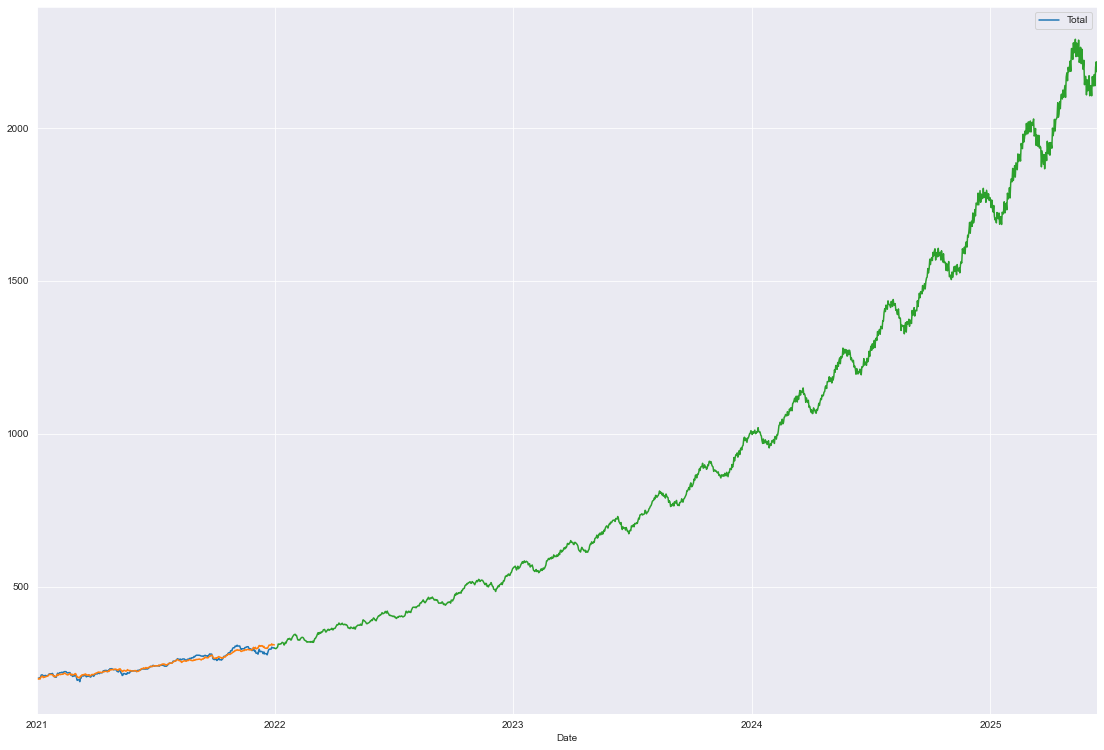

In [26]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [27]:
forecast

2021-12-31     298.725126
2022-01-01     298.059441
2022-01-02     296.968383
2022-01-03     297.660197
2022-01-04     299.908232
                 ...     
2025-06-09    2174.688245
2025-06-10    2137.872170
2025-06-11    2199.169884
2025-06-12    2216.307243
2025-06-13    2183.716969
Freq: D, Length: 1261, dtype: float64

In [28]:
forecast_df = pd.DataFrame(forecast)

In [29]:
forecast_df

,0
2021-12-31,298.725126
2022-01-01,298.059441
2022-01-02,296.968383
2022-01-03,297.660197
2022-01-04,299.908232
...,...
2025-06-09,2174.688245
2025-06-10,2137.872170
2025-06-11,2199.169884
2025-06-12,2216.307243


In [30]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [31]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.002228
2022-01-02,-0.005881
2022-01-03,-0.003565
2022-01-04,0.003961
...,...
2025-06-09,6.279897
2025-06-10,6.156653
2025-06-11,6.361851
2025-06-12,6.419219


In [32]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  48.862367
